In [5]:
from tensorflow.keras.applications import VGG16

# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

In [8]:
import os
import zipfile

# 1) 압축 풀기
local_zip = '/content/raccoon_dog_raccoon.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

(168, 300, 3)


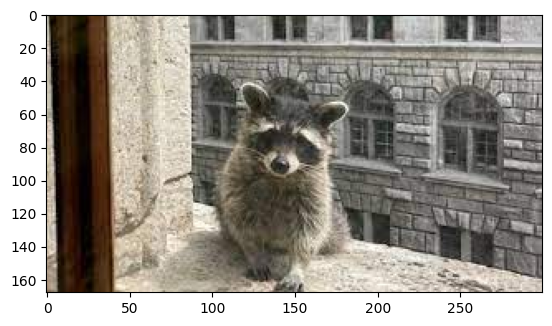

In [9]:
show_image("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

In [10]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)

    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

In [11]:
processed_image = load_and_process_image("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

Original image shape:  (168, 300, 3)
Processed image shape:  (1, 224, 224, 3)


In [12]:
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(168, 300, 3)
Original image shape:  (168, 300, 3)
Processed image shape:  (1, 224, 224, 3)
35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n02092002', 'Scottish_deerhound', 0.3231131), ('n02437616', 'llama', 0.29768026), ('n02090721', 'Irish_wolfhound', 0.03674607)]]


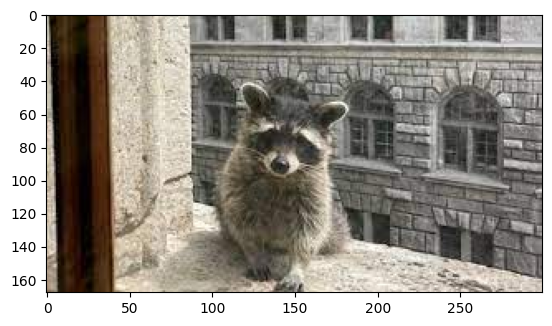

In [13]:
readable_prediction("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

(142, 355, 3)
Original image shape:  (142, 355, 3)
Processed image shape:  (1, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
Predicted: [[('n02447366', 'badger', 0.13890468), ('n02109961', 'Eskimo_dog', 0.09669977), ('n02114548', 'white_wolf', 0.070037425)]]


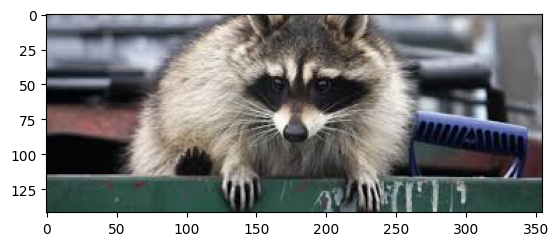

In [14]:
readable_prediction("/content/raccoon_dog_raccoon/raccoon/raccoon_2.jpg")

In [15]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
base_model.trainable = False

In [18]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

In [22]:
import os
import shutil
import random

# 데이터셋 디렉토리
dataset_dir = '/content/raccoon_dog_raccoon'

# 훈련 데이터와 검증 데이터를 저장할 디렉토리 생성
train_dir = '/content/train_data/'
validation_dir = '/content/validation_data/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# 클래스 목록
classes = ['raccoon', 'raccoon_dog']

# 훈련 데이터와 검증 데이터 비율 설정
train_ratio = 0.9  # 훈련 데이터 비율
validation_ratio = 0.1  # 검증 데이터 비율
random.seed(777) #랜덤시드고정

# 각 클래스에 대해 훈련과 검증 데이터로 나누기
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)  # 이미지 섞기

    # 이미지 개수 계산
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # 훈련 데이터 복사
    for image in images[:train_size]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

    # 검증 데이터 복사
    for image in images[train_size:]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

print("데이터 분리 완료.")

데이터 분리 완료.


In [23]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/train_data',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='binary',
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/content/validation_data',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=8)

Found 400 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [24]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=50)

Epoch 1/50
12/12 [==============================] - 6s 192ms/step - loss: 2.6735 - binary_accuracy: 0.3854 - val_loss: 1.8684 - val_binary_accuracy: 0.4375
Epoch 2/50
12/12 [==============================] - 3s 221ms/step - loss: 1.5319 - binary_accuracy: 0.5521 - val_loss: 1.1614 - val_binary_accuracy: 0.5938
Epoch 3/50
12/12 [==============================] - 3s 265ms/step - loss: 0.9833 - binary_accuracy: 0.6458 - val_loss: 1.0347 - val_binary_accuracy: 0.6562
Epoch 4/50
12/12 [==============================] - 2s 169ms/step - loss: 0.9246 - binary_accuracy: 0.6667 - val_loss: 0.3859 - val_binary_accuracy: 0.7812
Epoch 5/50
12/12 [==============================] - 2s 163ms/step - loss: 0.7819 - binary_accuracy: 0.7917 - val_loss: 0.7898 - val_binary_accuracy: 0.7812
Epoch 6/50
12/12 [==============================] - 4s 310ms/step - loss: 0.6968 - binary_accuracy: 0.7396 - val_loss: 0.7008 - val_binary_accuracy: 0.8750
Epoch 7/50
12/12 [==============================] - 6s 522ms/ste

In [25]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [26]:
history = model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 10s 224ms/step - loss: 0.4622 - binary_accuracy: 0.8750 - val_loss: 0.5197 - val_binary_accuracy: 0.8750
Epoch 2/20
12/12 [==============================] - 3s 249ms/step - loss: 0.2323 - binary_accuracy: 0.8854 - val_loss: 0.5009 - val_binary_accuracy: 0.8750
Epoch 3/20
12/12 [==============================] - 2s 188ms/step - loss: 0.2431 - binary_accuracy: 0.9167 - val_loss: 0.5424 - val_binary_accuracy: 0.8438
Epoch 4/20
12/12 [==============================] - 2s 199ms/step - loss: 0.2422 - binary_accuracy: 0.9375 - val_loss: 0.2634 - val_binary_accuracy: 0.8750
Epoch 5/20
12/12 [==============================] - 2s 202ms/step - loss: 0.2641 - binary_accuracy: 0.9167 - val_loss: 0.6724 - val_binary_accuracy: 0.7500
Epoch 6/20
12/12 [==============================] - 3s 241ms/step - loss: 0.2769 - binary_accuracy: 0.9167 - val_loss: 0.4626 - val_binary_accuracy: 0.9062
Epoch 7/20
12/12 [==============================] - 2s 201ms/st

In [27]:
model.evaluate_generator(valid_it)

<ipython-input-27-fdc6348bc2ac>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_it)


[1.2421585321426392, 0.739130437374115]

In [28]:
model.evaluate_generator(train_it)

<ipython-input-28-d2ac2afd28c5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_it)


[0.5553926825523376, 0.8700000047683716]

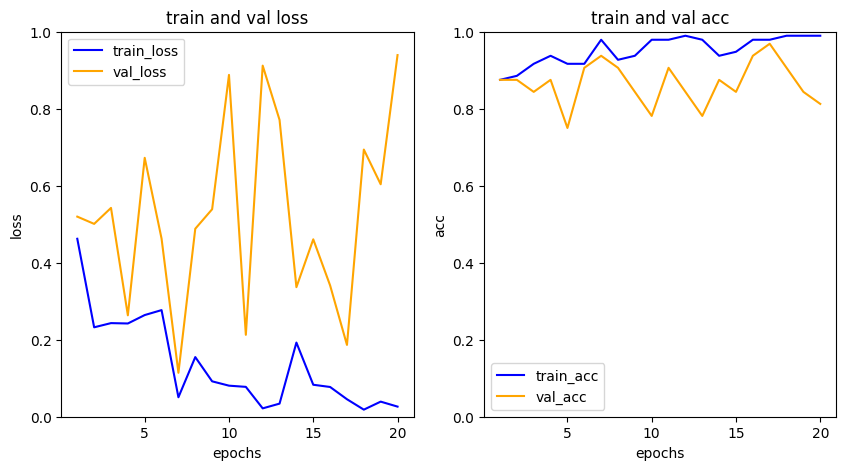

In [29]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['binary_accuracy']
val_acc = his_dict['val_binary_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

plt.show()

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 0s 144ms/step


array([[-3.931537]], dtype=float32)

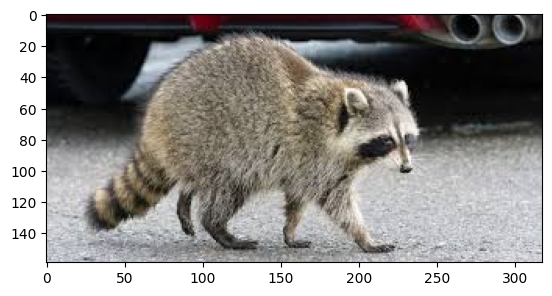

In [31]:
make_predictions('/content/raccoon_dog_raccoon/raccoon/raccoon_43.jpg')

1/1 [==============================] - 0s 18ms/step


array([[22.476553]], dtype=float32)

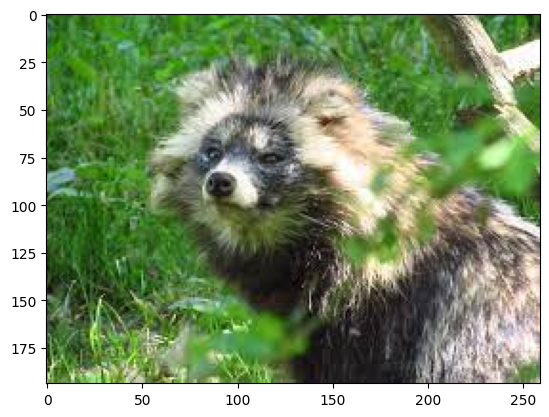

In [32]:
make_predictions('/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_1.jpg')

In [33]:
def fish(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's raccoon!, alien species")
    else:
        print("It's raccoon_dog! Korean species!")

1/1 [==============================] - 0s 36ms/step
It's raccoon_dog! Korean species!


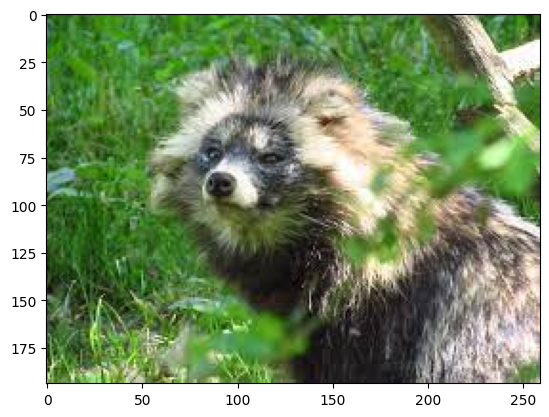

In [34]:
fish('/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_1.jpg')

1/1 [==============================] - 0s 45ms/step
It's raccoon!, alien species


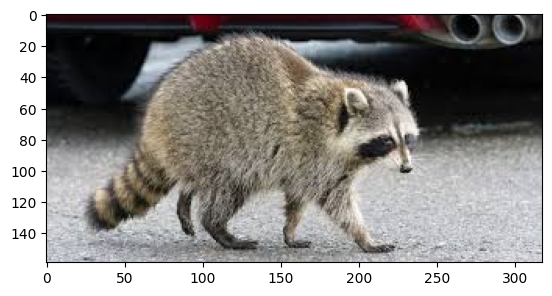

In [37]:
fish('/content/raccoon_dog_raccoon/raccoon/raccoon_43.jpg')

In [36]:
model.save('/content/vgg16_model.keras')